## Install and Import Dependencies

In [29]:
!pip install tensorflow pandas numpy re random seaborn matplotlib

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import re
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

## Load Dataset

In [3]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


with open(path_to_file) as f:
    text = f.read().lower()

## Text Preprocessing

In [4]:
def clean_shakespeare(text):
    text = re.sub(r'\[.*?\]', '', text)    # Remove stage directions
    text = re.sub(r'\n+', '\n', text)      # Remove multiple newlines
    text = re.sub(r'[()":;*]', '', text)   # Remove special characters
    text = re.sub(r'  +', ' ', text)       # Remove extra spaces
    return text

cleaned_text = clean_shakespeare(text)
lines = cleaned_text.split('\n')[:2000]

## Tokenization

In [5]:
tokenizer = Tokenizer(
    oov_token = "<OOV>",
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
tokenizer.fit_on_texts(lines)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

## Creating Sequences

In [6]:
input_sequences = []
for line in lines:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max(len(seq) for seq in input_sequences)
input_sequences = np.array(
    pad_sequences(input_sequences, maxlen=max_sequence_len, padding = 'pre')
)

## Preparing Data for Model Training

In [7]:
xs = input_sequences[:, :-1]
labels = input_sequences[:, -1]

ys = to_categorical(labels, num_classes=vocab_size)

## Model Architecture

In [8]:
model_shake = Sequential([
    Embedding(vocab_size, 256, input_length = max_sequence_len-1),
    Bidirectional(LSTM(512, return_sequences = True)),
    Dropout(0.3),
    LSTM(256),
    Dense(512, activation = 'relu'),
    Dense(vocab_size, activation = 'softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Model Configuration

In [9]:
model_shake.compile(optimizer = 'adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy']
)

## Model Training

In [10]:
shake_history = model_shake.fit(xs, ys, epochs = 90, verbose = 1)

model_shake.save('text_gen_shake.keras')

Epoch 1/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.0316 - loss: 6.8041
Epoch 2/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0512 - loss: 6.0945
Epoch 3/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0487 - loss: 5.9464
Epoch 4/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0572 - loss: 5.7595
Epoch 5/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0634 - loss: 5.5962
Epoch 6/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0686 - loss: 5.4699
Epoch 7/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0821 - loss: 5.3332
Epoch 8/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.0910 - loss: 5.1763
Epoch 9/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1048 - loss: 5.0198
Epoch 10/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1120 - loss: 4.9006
Epoch 11/90
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1135 - loss: 4.7926
Epoch 12/90
306/306 ━━━━━━━━━━━━━━━━━━━━

### Visualization

In [24]:
df = pd.DataFrame(shake_history.history)
df['Epoch'] = df.index + 1

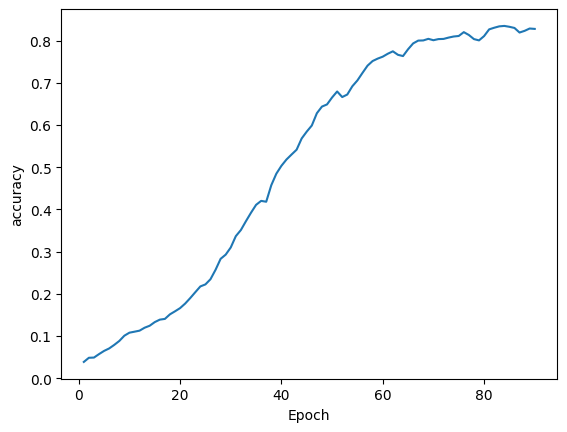

In [30]:
seaborn.lineplot(x = 'Epoch', y = 'accuracy', data = df)
plt.show()

## Text Generator Function

In [11]:
def generate_shakespeare_text(seed_text, next_words = 50, temperature = 0.7):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')

        predicted_probs = model_shake.predict(token_list, verbose = 0)[0]

        eps = 1e-7
        scaled_logits = np.log(predicted_probs + eps) / temperature
        exp_preds = np.exp(scaled_logits)
        predicted_probs = exp_preds / np.sum(exp_preds)

        predicted_id = np.random.choice(range(vocab_size), p = predicted_probs)
        output_word = tokenizer.index_word.get(predicted_id, "<OOV>")

        # Handle unknown words by selecting a random known word
        if output_word == "<OOV>":
            output_word = random.choice(list(tokenizer.word_index.keys()))

        seed_text += " " + output_word

    return seed_text

## Sample Predictions

In [12]:
print(generate_shakespeare_text("to be or not to be", next_words = 10))

to be or not to be to him then as our good wills in all with


In [18]:
print(generate_shakespeare_text("to be or not to be", next_words = 10, temperature = 0.1))

to be or not to be to him then as our good selves and one scratch


In [19]:
print(generate_shakespeare_text("to be or not to be", next_words = 10, temperature = 1))

to be or not to be to him then as our good wills in all they
